# Twitter Sentiment Classification

## Introduction
Sentiment classification is the task of detecting whether a textual item (e.g., a product review, a blog post, an editorial, etc.) expresses a POSITIVE or a NEGATIVE opinion (or more complex variaty of sentiments) in general or about a given entity, e.g., a product, a person, a political party, or a policy.

Classifying tweets according to sentiment has many applications in political science, social sciences, market research, and many others. Assume the condition that Apple wants to know how customers think about the new released iPhoneX. One of the ways Apple can dig into is to analyze the overall sentiment of tweets with a hashtag of #iPhoneX.

This tutorial will use ***Keras Deep Learning API with Theano backend***. It goes through the whole classification problem, including data preprocessing, word embedding, model building, model training and model evaluating.

## Installation
* Keras: ```sudo pip install keras```   
* Theano and TensorFlow (Two backends for Keras, we choose to use Theano in this tutorial, but Keras requires you to download both)   
    * Theano:   
        * Mac OS: ```sudo pip install Theano```   
        * Ubuntu: ```sudo pip install git+https://github.com/Theano/Theano.git#egg=Theano```   
    * TensowFlow: ```pip install --upgrade tensorflow```   


## Data Overview
Data used for this tutorial is from: http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4d-english.zip. Data is splitted into three parts: training dataset, validation dataset and test dataset, with size of 6000, 2000, 2000 respectively. Each line of data contains 4 columns: **tweet id, hashtag, sentiment, text**. Text column represents the input content, and the sentiment column represents labels. There are 2 kinds of sentiments in our data: **negative, positive**.

In [540]:
raw_train_path = "./train.tsv"  # 4346 lines
raw_validation_path = "./dev.tsv"  # 1325 lines
raw_test_path = "./test.tsv"   # 1417 lines

with open(raw_train_path, "r") as train:
    raw_train = train.readlines()
with open(raw_validation_path, "r") as valid:
    raw_valid = valid.readlines()
with open(raw_test_path, "r") as test:
    raw_test = test.readlines()

print(len(raw_train), len(raw_valid), len(raw_test))
for i in range(5):
    print(raw_train[i])

4346 1325 1417
628949369883000832	@microsoft	negative	dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.

628976607420645377	@microsoft	negative	@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!

629023169169518592	@microsoft	negative	Not Available

629179223232479232	@microsoft	negative	Not Available

629226490152914944	@microsoft	positive	Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft



## Data Preprocessing

As we can see from the raw data, some text contents are "Not Avaiable", and for the texts that do have meaningful contents, we can do some preprocessing.

1. Remove "Not Available".
2. Lowercase all texts.
3. Replace URL links with a specific token LINK with <>.
4. Replace user mention information with a specific token MENTION with <>.
5. Replace numbers with a specific token NUMBER with <>.
6. Remove punctuations except '#' for hashtags, '<>' for tokens above.
7. Merge multiple continuous spaces as a single space.
8. Transform labels "negative", "positive" to 0, 1 respectively, for the convenience of later label indexing.

Steps 3~7 are achieved by regular expression. The patterns are written below.

We will do data preprocessing on all three datasets. One thing I could mention here is, ***modifying test dataset is not cheating***. Since we are not actually looking at the test dataset, we just simply do whatever we do to the other two datasets with our "eyes closed". 

In [576]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, concatenate, Flatten, Input
from keras.layers import LSTM, GRU
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.convolutional import ZeroPadding1D
from keras.optimizers import RMSprop, SGD
from keras.backend import shape
from keras.callbacks import EarlyStopping

import numpy as np
import re

In [507]:
pattern_space = re.compile(r'\s+')
pattern_http = re.compile(r'https?://\S+')
pattern_punct = re.compile(r'[!\"\$&\'\(\)\*\+,\-\./:;=\?@\[\\\]\^_`\{\|\}~]')
pattern_mention = re.compile(r'@\S+')
pattern_number = re.compile(r'(\d+)((,|\.)\d+)*')

In [541]:
# data cleaning
def clean(data):
    cleaned = []
    for line in data:
        fields = line.strip().split('\t')
        if fields[-1] == "Not Available":
            continue
        
        # lowercase all texts
        fields[-1] = fields[-1].lower()
        # replace url_links, user_mentions and numbers with specific tokens
        fields[-1] = pattern_http.sub("<LINK>", fields[-1])
        fields[-1] = pattern_mention.sub("<MENTION>", fields[-1])
        fields[-1] = pattern_number.sub("<NUMBER>", fields[-1])
        # remove punctuations
        fields[-1] = pattern_punct.sub(' ', fields[-1])
        # merge multiple spaces into a single space
        fields[-1] = pattern_space.sub(' ', fields[-1]) 
        
        # transform labels
        if fields[2] == 'negative':
            label = 0
        else:
            label = 1
        cleaned.append((fields[-1], label))
            
    return cleaned

train = clean(raw_train)
valid = clean(raw_valid)
test = clean(raw_test)

for i in range(5):
    print(train[i])

('dear <MENTION> the newooffice for mac is great and all but no lync update c mon ', 0)
('<MENTION> how about you make a system that doesn t eat my friggin discs this is the <NUMBER>nd time this has happened and i am so sick of it ', 0)
('microsoft i may not prefer your gaming branch of business but you do make a damn fine operating system #windows<NUMBER> <MENTION>', 1)
('<MENTION> <MENTION> i will be downgrading and let #windows<NUMBER> be out for almost the <NUMBER>st yr b<NUMBER> trying it again #windows<NUMBER>fail', 0)
('<MENTION> <NUMBER>nd computer with same error #windows<NUMBER>fail guess we will shelve this until sp<NUMBER> <LINK>', 0)


We can see that texts are cleaner right now! 

Then we should split 3 datasets into two parts for each one: texts (input X) and labels (output Y). The distribution of labels in 3 datasets is shown in the below figure.

In [513]:
def split_xy(data):
    x = list(map(lambda k:k[0], data))
    y = list(map(lambda k:k[1], data))
    return x, y

train_X, train_Y = split_xy(train)
valid_X, valid_Y = split_xy(valid)
test_X, test_Y = split_xy(test)

### Prepare X
Since Keras doesn't accept real English words as input sequence, we have to transform input X into a sequence of numbers. Keras provides a ```Tokenizer``` which has a field of ```word_index```. It gives every unique word (tokenized by this ```Tokenizer```) a unique number to represent it. It returns a dictionary whose key is word, and value is an integer number. The size of this dictionary is the total number of unique words in out datasets. Then we can use this dictionary to convert the input text into corresponding word index sequences. Since Keras requires the input length to be fixed, so we should pad all the sequences into a fix length. I set this ```maxlen=140``` because the longest tweet can only contain 140 characters.

### Prepare Y
Since this is a binary classification problem, i.e. only have 2 different labels in dataset, we can just use 0/1 to represent labels, since labels can be fully represented by only one binary digit. If we have more than 2 different labels, we should convert each label as a one-hot vector and feed them into the neural network. Keras provides a method called ```to_categorical``` to help us achieve that.

In [515]:
def process_x(x):
    tk = Tokenizer()
    tk.fit_on_texts(x)
    word_index = tk.word_index
    index_list = tk.texts_to_sequences(x)
    x = pad_sequences(index_list, maxlen=INPUT_LENGTH)
    return x, word_index

def process_y(y):
#     return to_categorical(y, num_classes=NB_CLASSES)
    return np.array(y)

def process_xy(x, y):
    x, word_index = process_x(x)
    y = process_y(y)
    return x, y, word_index

train_X, train_Y, word_index_train = process_xy(train_X, train_Y)
valid_X, valid_Y, word_index_valid = process_xy(valid_X, valid_Y)
test_X, test_Y, word_index_test = process_xy(test_X, test_Y)

word_index_train.update(word_index_valid)
word_index_train.update(word_index_test)
word_index = word_index_train

print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)
print(test_X.shape, test_Y.shape)
print(len(word_index))

(3649, 140) (3649,)
(1124, 140) (1124,)
(1179, 140) (1179,)
11385


After preprocessing, 3 datasets contain 3649, 1124, 1179 lines respectively, and the input of each sample has dimension of 140, the output of each sample has dimension of 1.

Why did I merge 3 data index dictionaries into a single one? Because I want to calculate the maximum number of features in our model, which will be used as a parameter to feed in our neural network. Since each word is regarded as a feature, the total number of unique words over all 3 datasets is the maximum number of features. For our datasets, we have 11385 features for input texts.

In [542]:
MAX_FEATURES = len(word_index)
EMBEDDING_DIMS = 300
EMBEDDING_FILE = "./glove.840B.300d.txt"
NUM_EPOCH = 1
BATCH_SIZE = 32
LR = 1e-3

## Word Embedding

I use a pre-trained word embedding file here, which can be downloaded via: http://nlp.stanford.edu/data/glove.840B.300d.zip. This file is trained using an unsupervised learning algorithm on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space. More specific details can be found in https://nlp.stanford.edu/projects/glove/.

First we will read in this embedding file and convert the word-vector relationship into a dictionary called ```embedding```. The total number of word representations is 2195884.

In [522]:
embedding = {}
with open(EMBEDDING_FILE, "r") as f:
    for line in f:
        values = line.split()
        word = values[0]
        try:
            vec = np.asarray(values[1:], dtype='float32')
        except:
            continue
        embedding[word] = vec

print('Total number of word vectors:', len(embedding))

Total number of word vectors: 2195884


Then we will convert all features in our datasets into corresponding word vectors using the ```embedding``` dictionary and ```word_index``` dictionary. For the word occurs in our datasets while doesn't occur in the embedding file, we will use an all-zeros vector to represent it.

In [523]:
embedding_matrix = np.zeros((MAX_FEATURES, EMBEDDING_DIMS))  # initialize as all-zeros
for word, i in word_index.items():
    vec = embedding.get(word)
    if vec is not None:
        embedding_matrix[i] = vec

## Model Building

Here I designed a neural network model which concatenates the output of a Convolutional Neural Network (CNN) and a Gated Recurrent Neural Network (GRNN). The purpose of doing this is that CNN is now recognized as a great way for text analysis. Moreover, the recurrent technique in RNN can analyze the context of a text, i.e. analyze according to previous words, which may help generate more accuate features. 

The overall structure of my model is shown in the below figure.

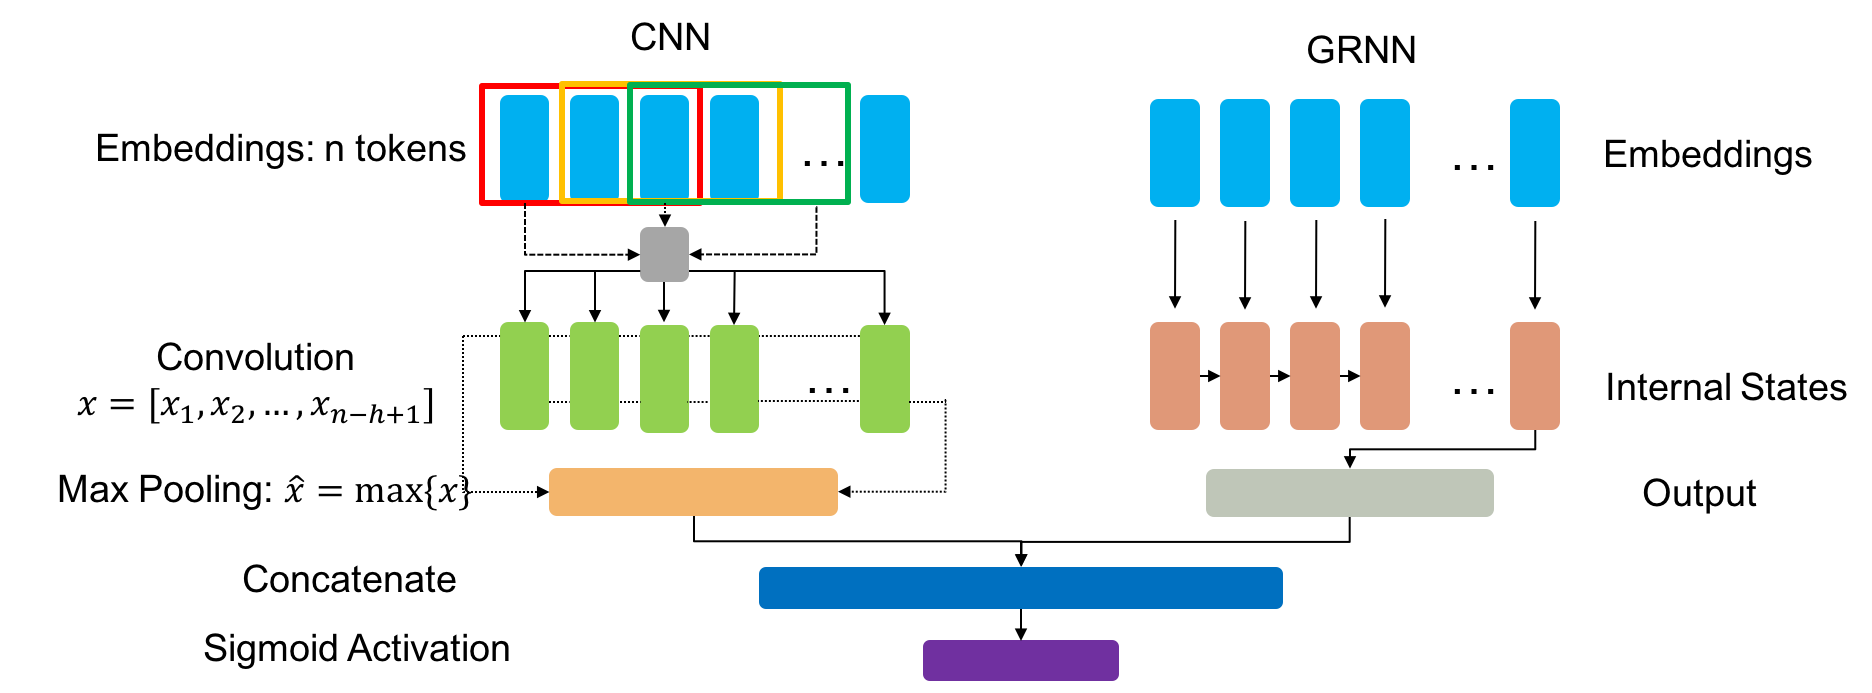

### CNN Model
For the CNN model, I first add an embedding layer to transfer input index sequences into word vector sequences. Then I add two pairs of ```Conv1D``` layer and ```MaxPolling1D``` layer for extracting features (in the figure, there's only one pair of these two layers). The reason for setting convolutional window size as 3 is that, since out input has a maximum length of 140, which is a relative small size, we should use a small window size to extract features. Since we want the output to have dimension of 1, so I add a ```Flatten``` layer. Then I add a ```Dense``` layer with activation function of ```relu``` and output dimension of 250. At last I add a ```Dropout``` layer with a parameter of 0.7 to prevent overfitting.

In [553]:
# cnn model
sequence_input_1 = Input(shape=(140,), dtype='int32', name='input_cnn')
embedded_sequences_1 = Embedding(MAX_FEATURES,
                        EMBEDDING_DIMS,
                        weights=[embedding_matrix],
                        input_length=140,
                        trainable=False,
                        name='embedding_cnn')(sequence_input_1)
x1 = Conv1D(200, 3, activation='relu', kernel_initializer='random_uniform', bias_initializer='zeros', name="conv1d")(embedded_sequences_1)
x1 = MaxPooling1D(3, name="maxpooling1")(x1)
x1 = Conv1D(200, 3, activation='relu', name="conv2")(x1)
x1 = MaxPooling1D(3, name="maxpooling2")(x1)
x1 = Flatten(name="flatten")(x1)
x1 = Dense(250, activation='relu', name="dense1")(x1)
x1 = Dropout(0.7)(x1)

### RNN Model
For the RNN model, I also add an embedding layer for the same purpose as CNN. One thing I should mention here is that, even though CNN model and RNN model have exactly the same input and embedding technique, we must have **two separate ```Input``` layers and ```Embedding``` layers**! Since we will concatenate the output of these two models later, but before concatenation, these two model should not have any intersections.

Then I add a ```GRU``` layer with hidden units of 200, and a same ```Dense``` layer as CNN model with activation function as ```relu``` and output dimension of 250. Another thing I should mention here is that, for successful concatenation, the output dimension of two ```Dense``` layers must be the same.

In [554]:
# rnn model
sequence_input_2 = Input(shape=(140,), dtype='int32', name='input_rnn')
embedded_sequences_2 = Embedding(MAX_FEATURES,
                        EMBEDDING_DIMS,
                        weights=[embedding_matrix],
                        input_length=140,
                        trainable=False,
                        name='embedding_rnn')(sequence_input_2)
x2 = GRU(200, name='gru', kernel_initializer='random_uniform', bias_initializer='zeros')(embedded_sequences_2)
x2 = Dense(250, activation='relu', name='dense3')(x2)

### Merge Model
For merging models, I just simply concatenate the output of previous CNN and RNN models using method ```concatenate``` provided by Keras. Then I add a ```Dropout``` layer with parameter of 0.7. In the end, the output predictions is produced by a ```Dense``` layer with output dimension of 1 (0/1 for prediction label) and activation function of ```sigmoid```.

In [555]:
# merge model
x = concatenate([x1, x2], axis=1, name='concat')
x = Dropout(0.7, name='dropout_merge')(x)
preds = Dense(1, activation='sigmoid', name="dense_last")(x)

### Model Compiling

After finishing the architecture of this model, we can start building it. Mention here our input to this model is two copies of ```Input``` layer. Here I use the optimization scheme of "Stochastic Gradient Descent" with learning rate of ```1e-3```, decay of ```1e-6``` (represents learning rate decay over each update). For more information of ```SGD```, please check https://keras.io/optimizers/#sgd. Loss here is ```binary_crossentropy```. If we're dealing with more than 2 labels, we can use ```categorical_crossentropy``` instead.

We can see the details of our model by ```model.summary()``` provided by Keras. It describes the output shape, number of parameters and connection of every layer inside our model.

In [570]:
print("*************Start building model...*************")
model = Model([sequence_input_1, sequence_input_2], preds)

print(model.summary())

model.compile(loss='binary_crossentropy',
#              optimizer=RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0),
             optimizer=SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=False),
             metrics=['accuracy'])

print("*************Finish building model*************")

*************Start building model...*************
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cnn (InputLayer)          (None, 140)          0                                            
__________________________________________________________________________________________________
embedding_cnn (Embedding)       (None, 140, 300)     3415500     input_cnn[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 138, 200)     180200      embedding_cnn[0][0]              
__________________________________________________________________________________________________
maxpooling1 (MaxPooling1D)      (None, 46, 200)      0           conv1d[0][0]                     
___________________________________________________________

## Model Training
Keras provides a ```model.fit()``` method for model training. Here we set the batch size as 32 and train for 1 epoch.

In [573]:
print("*************Start training model...*************")
model.fit(
    [train_X,train_X], train_Y,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    validation_data=([valid_X,valid_X], valid_Y),
)
print("*************Finish training model*************")

*************Start training model...*************
Train on 3649 samples, validate on 1124 samples
Epoch 1/1
3649/3649 [==============================] - 79s 22ms/step - loss: 0.2129 - acc: 0.9148 - val_loss: 0.8154 - val_acc: 0.7278
*************Finish training model*************


## Model Evaluating
Keras provides a ```model.evaluate()``` method for model evaluating. Here we set the batch size the same value as ```model.fit()```.

In [575]:
print("*************Start evaluating model...*************")
acc = model.evaluate(x=[test_X,test_X], y=test_Y, batch_size=BATCH_SIZE)
print("test loss: {}, test accuacy: {}".format(acc[0], acc[1]))

*************Start evaluating model...*************
1179/1179 [==============================] - 5s 4ms/step
test loss: 0.5584670128814238, test accuacy: 0.8083121287205949


So our model can get nearly 80% accuacy.

## Reference
[1] Keras documentation: https://keras.io/   
[2] GloVe word embedding: https://nlp.stanford.edu/projects/glove/